In [10]:
from tqdm import tqdm
import requests
import zipfile
import io
import os
import shutil
import json
import csv
import random
import tarfile

import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Set up project directory structure and declare paths

Run every time, as sets constants for paths that are used elsewhere

In [21]:
DATA_DIR= "/home/ubuntu/baseline"
DOWNLOAD_DIR= DATA_DIR + "/download"
IMAGES_DIR= DATA_DIR + "/images"
TRAIN_DIR= DATA_DIR + "/train"
VAL_DIR= DATA_DIR + "/val"
DATA_EXT = ".zip"

if not os.path.isdir(DATA_DIR): 
    os.mkdir(DATA_DIR)

if not os.path.isdir(DOWNLOAD_DIR): 
    os.mkdir(DOWNLOAD_DIR)

## Download image dataset

**TIME CONSUMING Run only at project start or if you need to re-download dataset**

In [4]:
SERVER_URL="http://skuld.cs.umass.edu"
DATASET_PATH="traces/mmsys/2014"
ARCHIVE_NAME="user03.tar"

In [22]:
archive_path = f"{SERVER_URL}/{DATASET_PATH}/{ARCHIVE_NAME}"

In [6]:
print(f"Streaming data file from remote source: {archive_path}")

r = requests.get(archive_path, stream=True)

######## Show download progress
total_size_in_bytes= int(r.headers.get('content-length', 0))
block_size = 1024
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

## Stream and write to data.zip
with open(f"{DOWNLOAD_DIR}/{ARCHIVE_NAME}", 'wb') as file:
    for data in r.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
##

progress_bar.close()
if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    print("An error occurred during download.")
########
    
print("Retrieved dataset files from remote source")

Streaming data file from remote source: http://skuld.cs.umass.edu/traces/mmsys/2014/user03.tar


100%|█████████████████████████████████████| 85.1G/85.1G [40:36<00:00, 34.9MiB/s]

Retrieved dataset files from remote source


## Expand downloaded images

**TIME CONSUMING Run once or only if you want to re-expand files from downloaded Zips (e.g., if image folders get deleted)**

Also may need to re-run train/val split and augmentation below

In [7]:
def unzip_file(file_name,dest_path):
    zip_ref = zipfile.ZipFile(file_name) # create zipfile object
    zip_ref.extractall(dest_path) # extract file to dir
    zip_ref.close() # close file

In [9]:
print("Expanding and structuring dataset files")
######## Unzip main archive
#unzip_file(f"{DOWNLOAD_DIR}/{ARCHIVE_NAME}",DOWNLOAD_DIR)

Expanding and structuring dataset files


In [29]:

######## Unzip and structure data files
img_dir = f"{DOWNLOAD_DIR}/PhotoCollection"
meta_dir = f"{DOWNLOAD_DIR}/MMSys2014"

img_dir_listing = os.listdir(img_dir)
meta_dir_listing = os.listdir(meta_dir)

In [ ]:
for f,file in enumerate(meta_dir_listing): # loop through items in dir
    if file.endswith(DATA_EXT): # check for ".zip" extension
        file_name = f"{meta_dir}/{file}" # get full path of files
        print(f"{file_name}")
        unzip_file(file_name,DATA_DIR)

In [31]:
#If the image Zips are a multi-part archive, some manual concatenation and Zip fixing may be required on the command line
#Goal is to produce a single unzippable archive called images.zip

file = "images.zip"
file_name = f"{img_dir}/{file}" # get full path of files
print(f"{file_name}")
unzip_file(file_name,IMAGES_DIR)

/home/ubuntu/baseline/download/PhotoCollection/images.zip


BadZipFile: Bad CRC-32 for file '1/1055659889.jpg'

In [102]:
#Move images out of subfolders for flat images directory
for folder in ["1","2","3"]:
    subdir = f"{IMAGES_DIR}/{folder}"
    print(subdir)
    if os.path.isdir(subdir):
        for file in os.listdir(subdir):
            file_name = os.path.join(subdir, file)
            shutil.move(file_name, f"{IMAGES_DIR}/{file}")
        os.rmdir(subdir)
        
print("Expanded dataset files")

/home/ubuntu/baseline/images/1
/home/ubuntu/baseline/images/2
/home/ubuntu/baseline/images/3
Expanded dataset files


In [107]:
#Clean invalid images out of archive
for file in os.listdir(IMAGES_DIR):
    file_name = os.path.join(IMAGES_DIR, file)
    if os.stat(file_name).st_size == 0:
        os.remove(file_name)
        
print(f"Cleaned empty/expanded files. {len(os.listdir(IMAGES_DIR))} files remain.")

Cleaned empty/expanded files. 621444 files remain.


## Split images into train and val datasets

Run once or only if you want to re-split the dataset into train/val sets

In [87]:
print("Setting up train/val class directories")

if not os.path.isdir(TRAIN_DIR): 
    os.mkdir(TRAIN_DIR)
    os.mkdir(VAL_DIR)

with open(DATA_DIR + "/spatial-index/Tile-Quadtree-Regions.csv") as geo_file:
    geo = [{k.strip(): float(v) for k, v in row.items()} for row in csv.DictReader(geo_file, skipinitialspace=True) if row]

random.seed(1)
train_split = .8
    
with open(DATA_DIR + "/photo_metadata.csv") as meta_file:
    rows = csv.reader(meta_file)
    
    print("Moving images to train/val directories")
    
    for r,row in tqdm(enumerate(rows)):
        if (r == 0):
            id_index = row.index("id")
            lat_index = row.index("latitude")
            lng_index = row.index("longitude")
        else: 
            file = row[id_index] + ".jpg"
            file_name = os.path.join(IMAGES_DIR, file)
        
            if os.path.exists(file_name):
                
                split_index = random.uniform(0, 1)
                
                lat = float(row[lat_index])
                lng = float(row[lng_index])

                grid = next(filter(lambda g: lat >= g["Min Latitude"] and lat <= g["Max Latitude"] and lng >= g["Min Longitude"] and lng <= g["Max Longitude"], geo),None)

                if grid:
                    
                    region = str(int(grid["Quad-Tree Region ID"]))

                    if split_index <= train_split:
                        class_dir = TRAIN_DIR + "/" + region
                    else:
                        class_dir = VAL_DIR + "/" + region

                    if not os.path.isdir(class_dir):
                        os.mkdir(class_dir)
                        
                    shutil.move(file_name, class_dir)
                
                
print("Finished setting up train/val class directories")
            

Setting up train/val class directories
Moving images to train/val directories


14122721it [01:56, 120841.71it/s]

Finished setting up train/val class directories


## Calculate normalization values

**TIME CONSUMING Run once - probably do not need to run again**

In [92]:
print("Computing mean and standard deviation of image dataset for normalization")

psum = np.array([0.0, 0.0, 0.0])
psum_sq = np.array([0.0, 0.0, 0.0])
count_img = 0 
counts_img = {}

transform = transforms.ToTensor()

for directory in [TRAIN_DIR,VAL_DIR]:
    for item in os.listdir(directory):
        subdir = os.path.join(directory, item)
        if os.path.isdir(subdir):
            counts_img[item] = 0 
            for file in tqdm(os.listdir(subdir)):
                path = os.path.join(subdir, file)
                try:
                    image = transform(cv2.imread(path, cv2.COLOR_BGR2RGB))
                    psum = np.add(psum,torch.mean(image, dim = [1,2]))
                    psum_sq = np.add(psum_sq,torch.mean(image ** 2, dim = [1,2]))
                    counts_img[str(item)] += 1
                    count_img += 1
                except:
#                     print(f"Invalid image: {path}")
                    pass

total_mean = psum / count_img
total_var = (psum_sq / count_img) - (total_mean ** 2)
total_std = np.sqrt(total_var)

print(total_mean,total_std)

Computing mean and standard deviation of image dataset for normalization


100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 301.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:01<00:00, 231.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:01<00:00, 242.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.60it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 199.74it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 224.70it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 261.40it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 234.73it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 203.27it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 208.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 210.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 216.20it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 226.72it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.53it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 224.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 210.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 224.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:01<00:00, 214.66it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 239.29it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 221.18it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 190.71it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 243.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:01<00:00, 208.77it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 210.14it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.25it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 227.61it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 204.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:01<00:00, 218.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 182.68it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 291.11it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 322/322 [00:01<00:00, 210.70it/s]


 27%|███████████████████████▌                                                                | 61/228 [00:00<00:00, 198.14it/s]Premature end of JPEG file


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 177.66it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 230.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 216.67it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 179.89it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 207.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 221.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 200.26it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 230.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 185.24it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.94it/s]


tensor([0.3869, 0.4162, 0.4315], dtype=torch.float64) tensor([0.3015, 0.2849, 0.2924], dtype=torch.float64)


In [96]:
print(len(os.listdir(TRAIN_DIR)))

2756


## Indoor/outdoor classification 

### Split out files for labeling

In [113]:
OUTDOOR_DIR = DATA_DIR + "/../outdoor"
OUTDOOR_IMAGES_DIR = OUTDOOR_DIR + "/images"

random.seed(1)

#Copy images out of subfolders for classification
sample = random.sample(os.listdir(IMAGES_DIR),10000)
sample_index = 0
team = ["rashmi","varun","vasu","kevin"]
images_per_person = int(len(sample)/len(team))
for person in team:
    subdir = f"{OUTDOOR_IMAGES_DIR}/{person}"
    if not os.path.isdir(subdir): 
        os.mkdir(subdir)
    for i in range(0,images_per_person):
        file = sample[sample_index]
        file_name = os.path.join(IMAGES_DIR, file)
        shutil.copy(file_name, subdir)
        sample_index += 1

print(f"Moved {sample_index} files for classification to team member directories")

Moved 10000 files for classification to team member directories


## Augment dataset

**TIME CONSUMING Run once or if you re-run dataset unzipping/structuring above**

In [ ]:
from PIL import Image
from torchvision.io import read_image
from torchvision.utils import save_image

augment = transforms.TrivialAugmentWide()

def get_count(group,cls):
    return len(os.listdir(get_dir(group,cls)))

def get_counts():
    sets = {}
    maxes = {}
    for group in ["train","val"]:
        sets[group] = {}
        for i in range(0,len(geo)):
            cls = str(i)
            sets[group][cls] = get_count(group,cls)
        maxes[group] = np.max(list(sets[group].values()))
    return sets,maxes

def get_dir(group,cls):
    return os.path.join(TRAIN_DIR if group == 'train' else VAL_DIR,cls)

sets,maxes = get_counts()
print(sets,maxes)

#Only augment training images
for group in ["train"]:#,"val"]:
    for i in range(0,len(geo)):
        cls = str(i)
        img_count = sets[group][cls]
        img_max = maxes[group]
        if img_count != img_max:
            img_dir = get_dir(group,cls)
            listing = os.listdir(img_dir)
            #Check for _ char in filename - we don't want to re-augment our augmented images
            listing = [file for file in listing if "_" not in file]
            for count in tqdm(range(img_count,img_max),desc=f"Augmenting class {cls} images"):        
                path = os.path.join(img_dir,random.choice(listing))
                image = read_image(path).cuda()
                #Augment expects a ByteTensor but saving requires a 0-1-scaled FloatTensor, so convert via division
                image_out = augment(image)/255
                save_image(image_out,path.replace(".jpg",f"_{count}.jpg"))

{'train': {'0': 50998, '1': 13034, '2': 13410, '3': 8042}, 'val': {'0': 12836, '1': 3332, '2': 3243, '3': 1950}} {'train': 50998, 'val': 12836}


Augmenting class 3 images:  98%|███████▊| 42005/42956 [1:09:02<01:57,  8.07it/s]

## Optimize geo bins

Run once, manually move ideal number of bins to config below

In [5]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib import cm
import pickle

with open(DOWNLOAD_DIR + "/Vegetation_Survey.csv") as csvfile:
    data = [{k.strip(): v for k, v in row.items()} for row in csv.DictReader(csvfile, skipinitialspace=True, delimiter=';')]

def get_points():
    return np.array([get_geo(datum) for datum in data])

def get_geo(g):
    return [float(g["Longitude"]),float(g["Latitude"])]



 41%|█████████████████▋                         | 32/78 [11:05<25:52, 33.74s/it]


100%|█████████████████████████████████████████| 4/4 [4:13:58<00:00, 3809.55s/it]


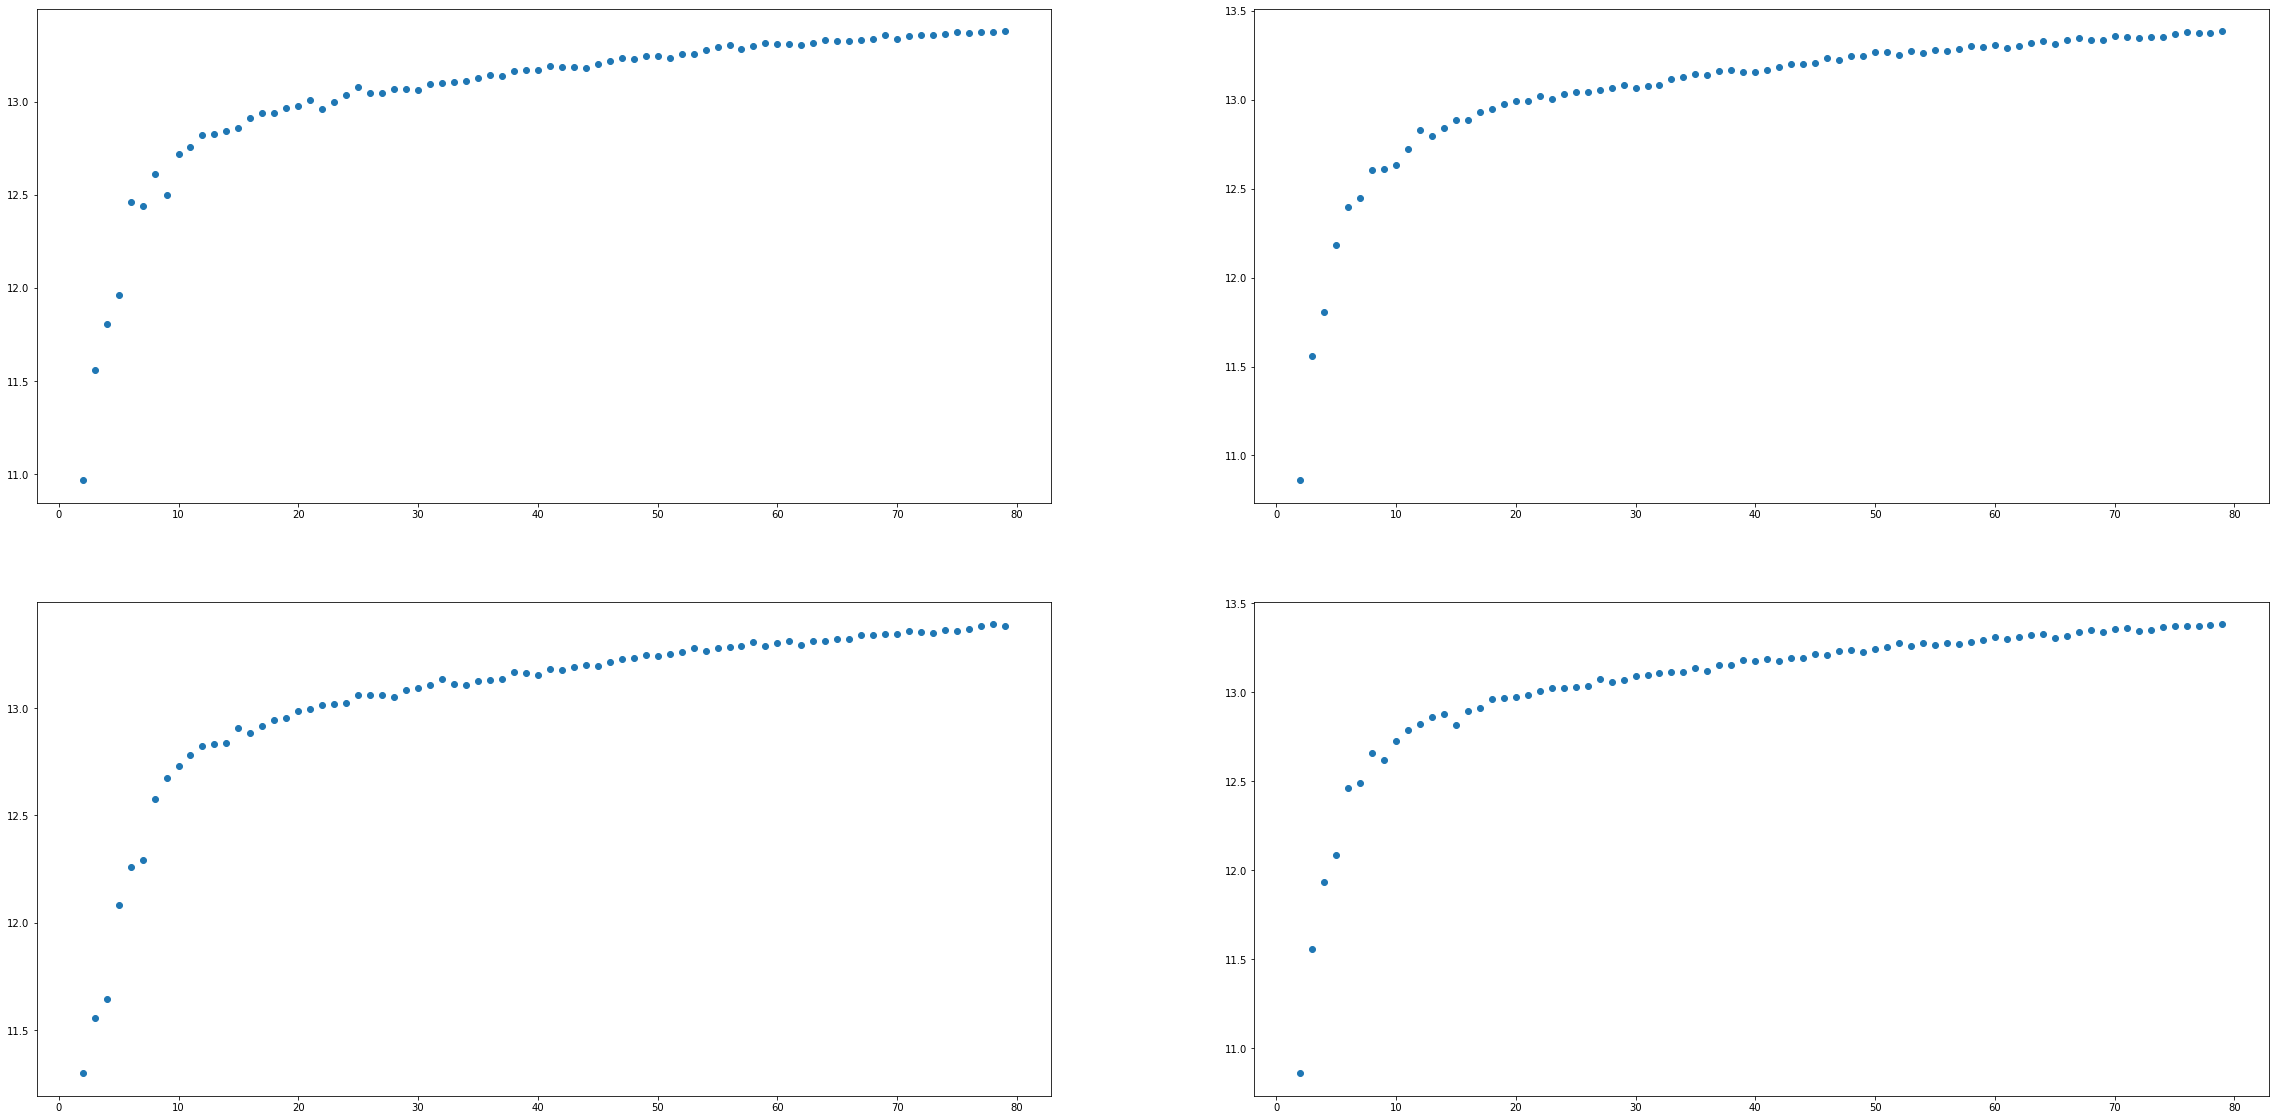

In [10]:
#BIC analysis
points = get_points()

gm_min = 2
gm_max = 80
num_runs = 4

fig,axes = plt.subplots(2,int(num_runs/2),figsize=(40,20))

#Iterate multiple times with multiple sets of points to see variations
for k in tqdm(range(0,num_runs)):
    #For performance, select a random selection of points rather than grouping on all 100k+
    #points = np.array(random.sample(list(points),500))
    gm_bic = []
    for i in tqdm(range(gm_min,gm_max), leave=False):
        gm = GaussianMixture(n_components=i,n_init=4,tol=1e-3,max_iter=1000).fit(points)
        gm_bic.append([i,np.log(-gm.bic(points))])

    gm_bic = np.array(gm_bic)
    row = int(np.floor(k / axes.shape[1]))
    col = int(k - (row * axes.shape[1]))
    axes[row,col].scatter(x=gm_bic[:, 0],y=gm_bic[:, 1])

In [31]:
#Silhouette score
#From: https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

from sklearn import metrics

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

points = get_points()

gm_min = 110
gm_max = 131
num_runs = 4
sils=[]
sils_err=[]

#Iterate multiple times with multiple sets of points to see variations
for i in tqdm(range(gm_min,gm_max)):
    #For performance, select a random selection of points rather than grouping on all 100k+
    #points = np.array(random.sample(list(points),100000))
    tmp_sil=[]
    for k in tqdm(range(0,num_runs), leave=False):
        gm = GaussianMixture(n_components=i,n_init=2,max_iter=100).fit(points)
        labels=gm.predict(points)
        sil=metrics.silhouette_score(points, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(num_runs/4)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

 33%|█████████████                          | 7/21 [1:32:58<3:05:56, 796.90s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Score')

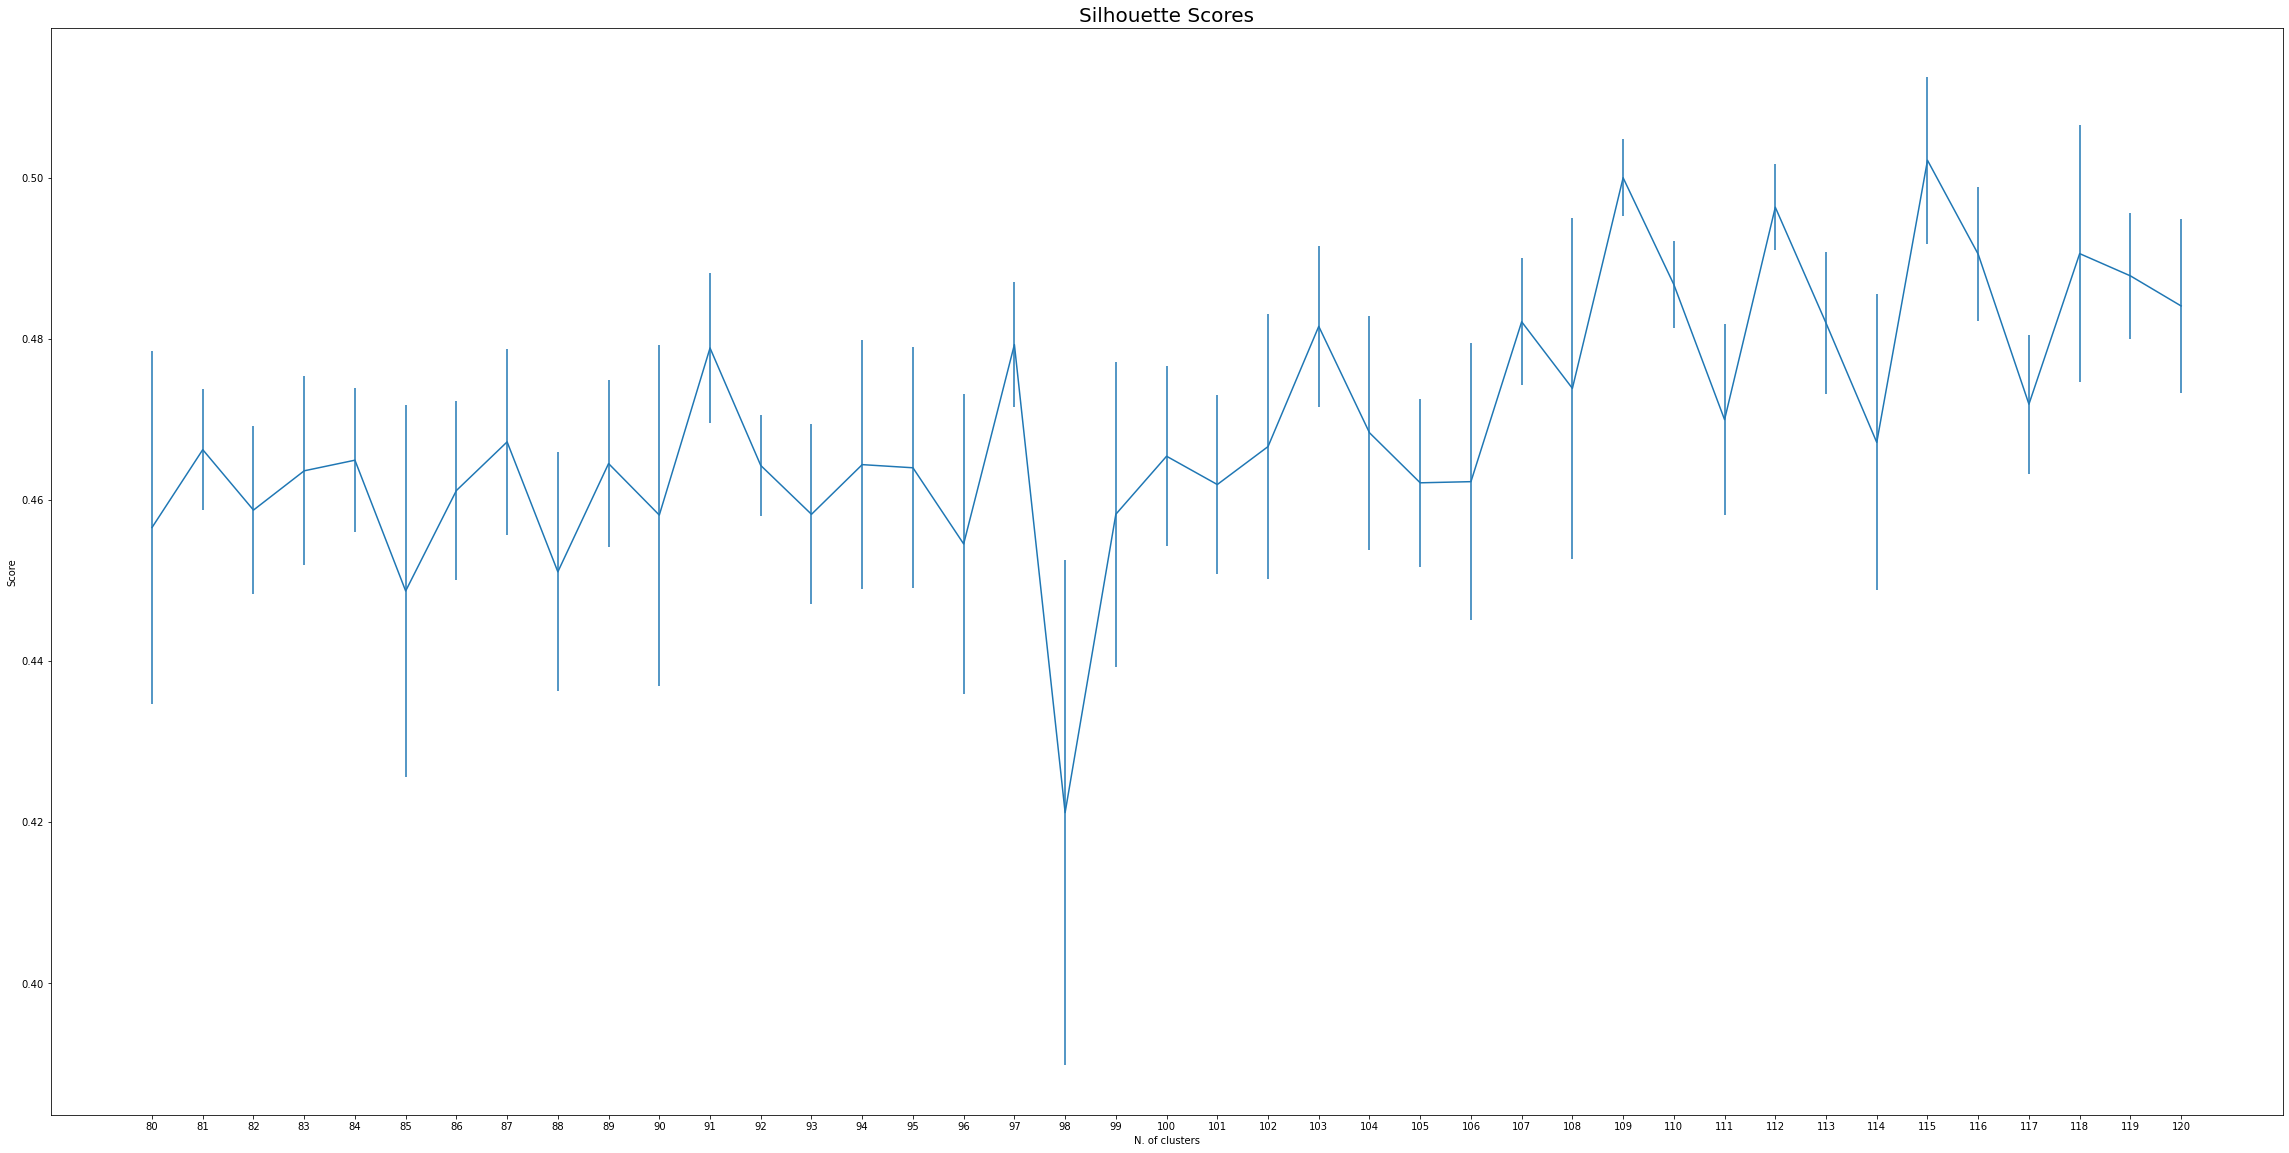

In [29]:
plt.figure(figsize=(40,20))
plt.errorbar(np.arange(gm_min, gm_max), sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(np.arange(gm_min, gm_max))
plt.xlabel("N. of clusters")
plt.ylabel("Score")

#### Output GMM bin weights for classification of geo locations

In [6]:
### Geo clustering w/ GMM
points = get_points()

### Derived from BIC and silhouette score analysis above
geo_classes = 19
classifier_geo = GaussianMixture(n_components=geo_classes,n_init=10,tol=1e-3,max_iter=1000)
classifier_geo.fit(points)

# save out GMM clusters for use in distributed model classification
with open('geo_model_gmm.pkl','wb') as f:
    pickle.dump(classifier_geo,f)

#### Test GMM clustering

19


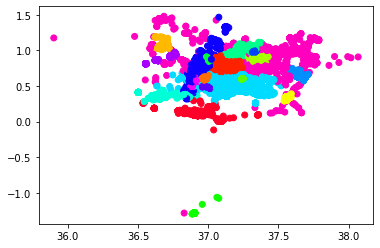

In [7]:
points = get_points()
sample = np.array(random.sample(list(points),50000))

with open('geo_model_gmm.pkl', 'rb') as f:
    classifier_geo = pickle.load(f)
    geo_classes = classifier_geo.weights_.shape[0]
    print(geo_classes)

labels = classifier_geo.predict(sample)

plt.scatter(x=sample[:,0],y=sample[:,1],c=labels,cmap='gist_rainbow')

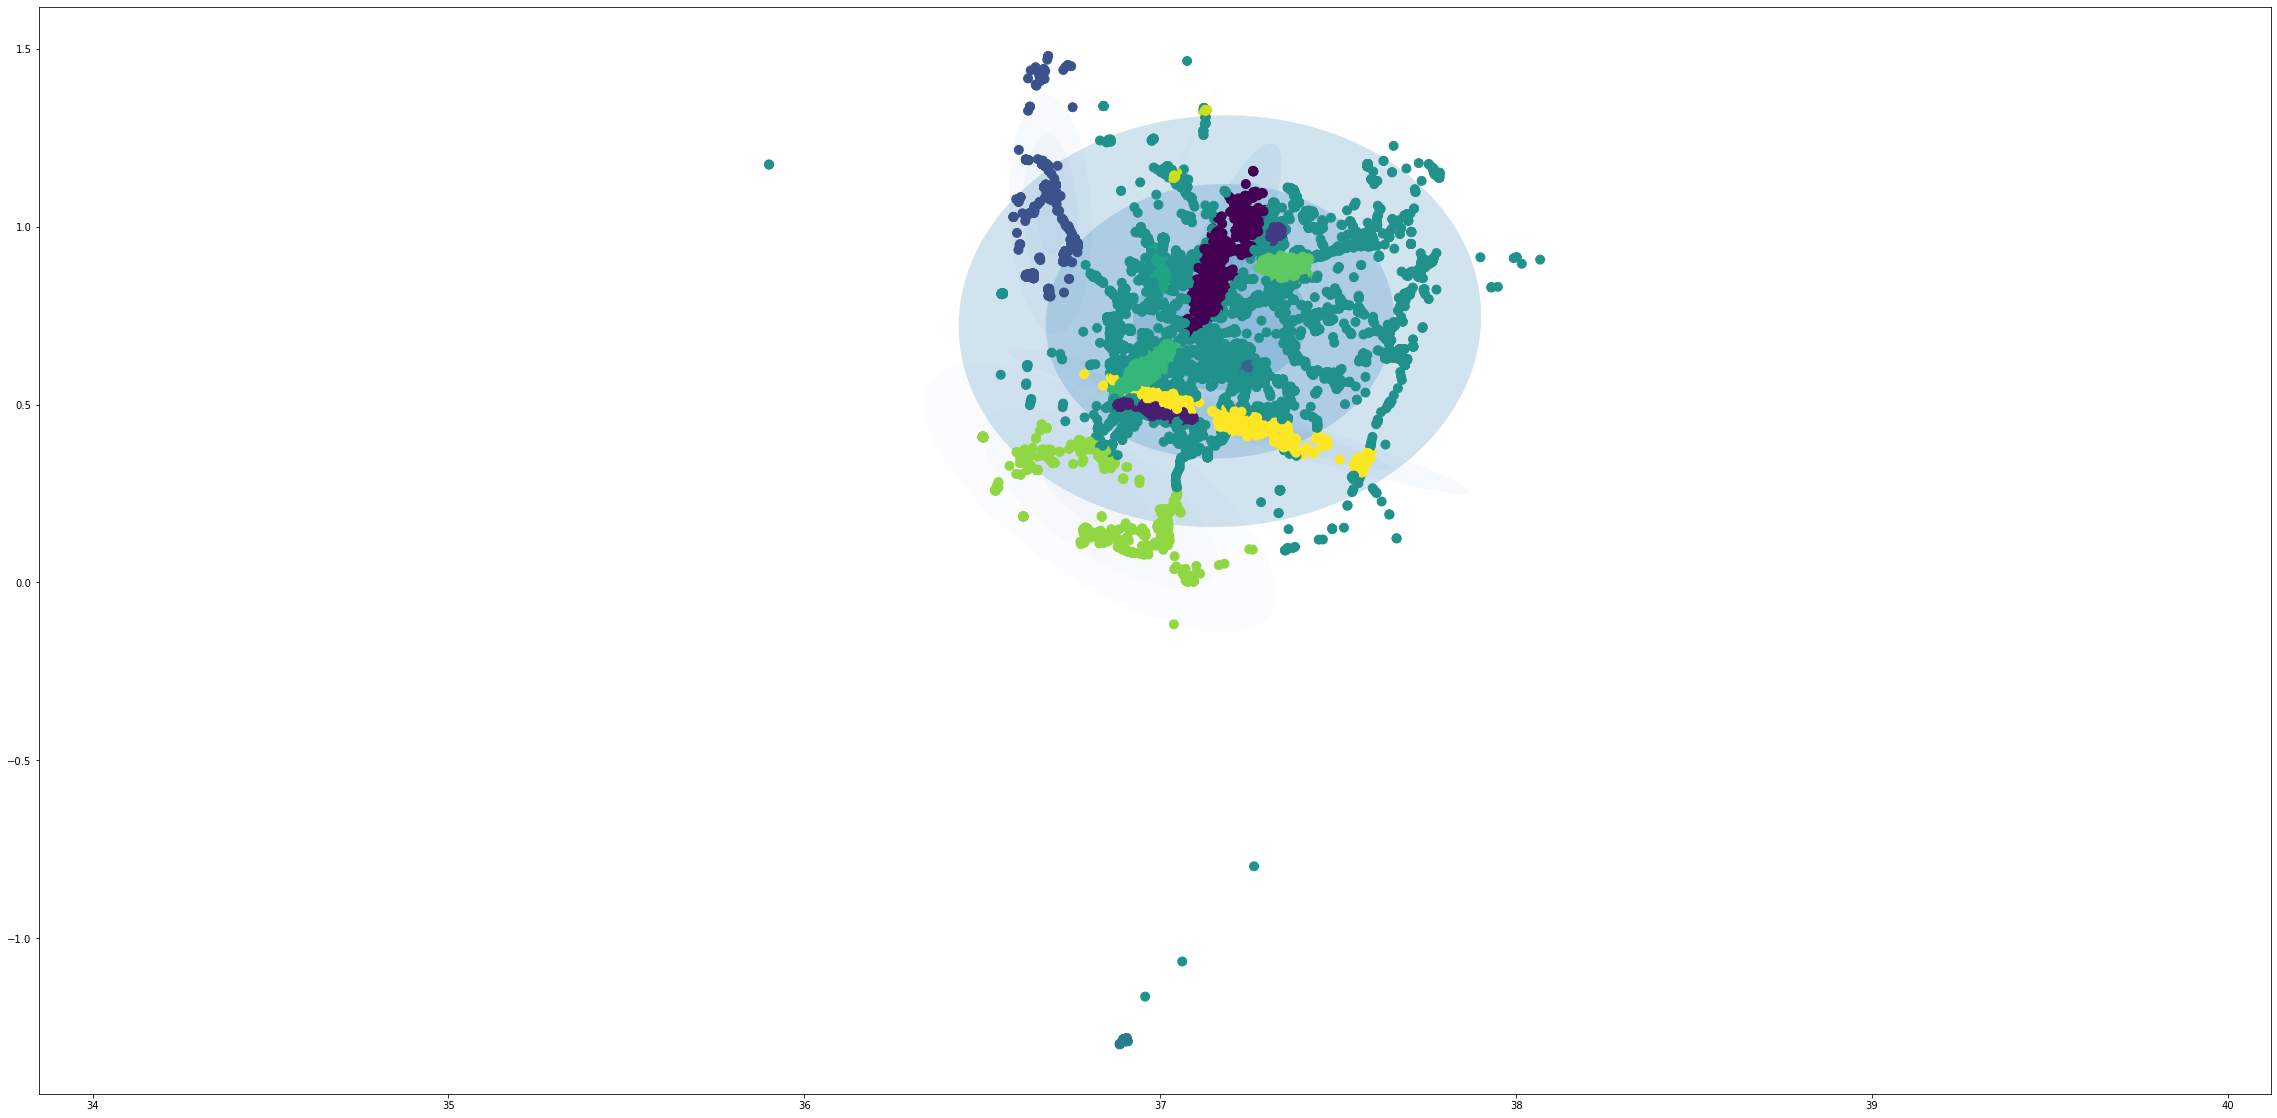

In [46]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, labels, label=True, ax=None):
    ax = ax or plt.gca()
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=80, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=80, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


plt.figure(figsize = (40,20))       
plot_gmm(classifier_geo, sample, labels)

#### KMeans clustering

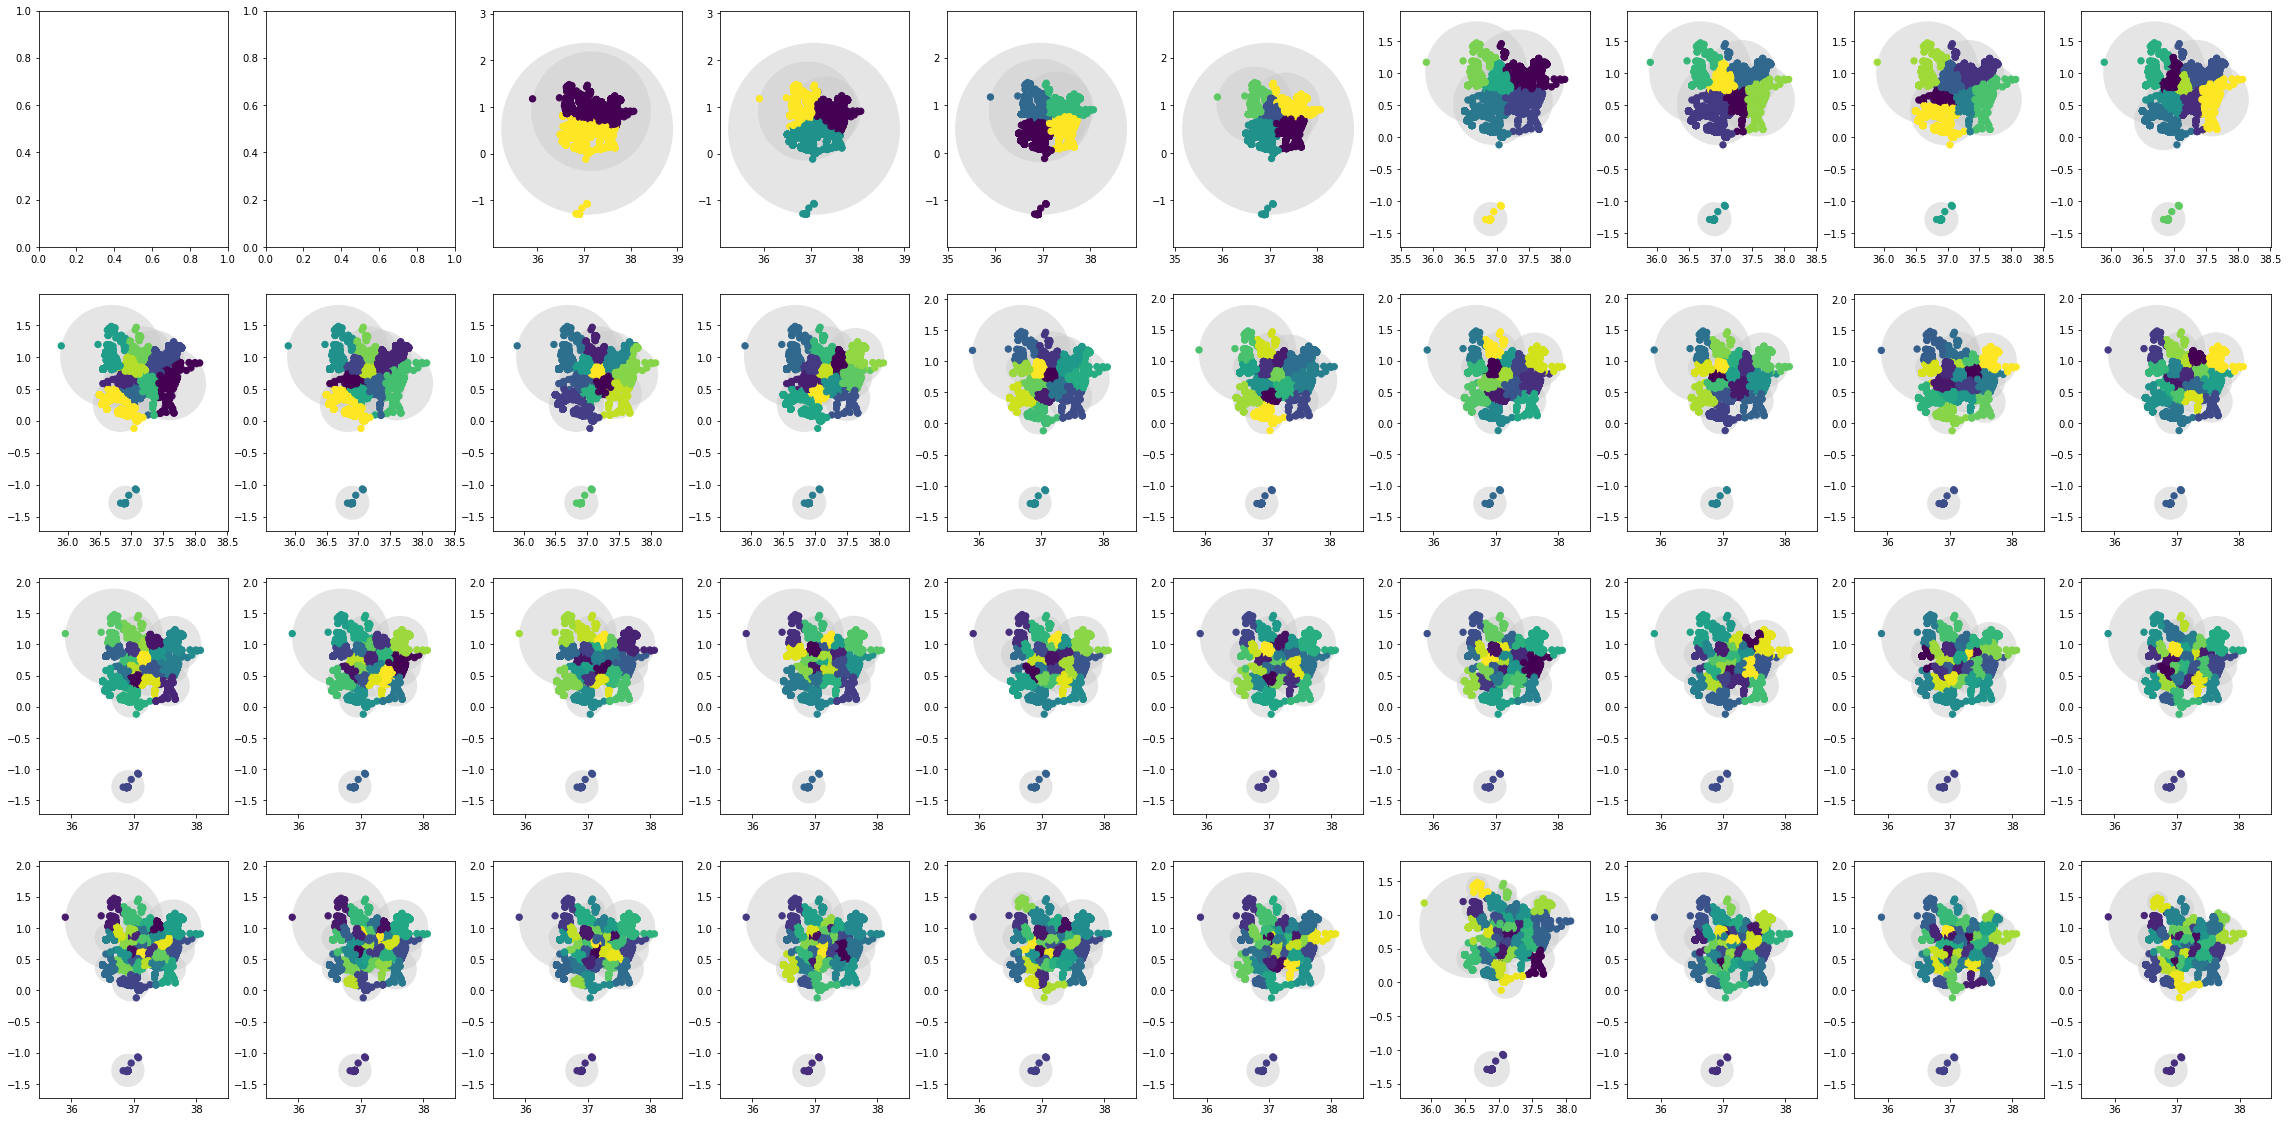

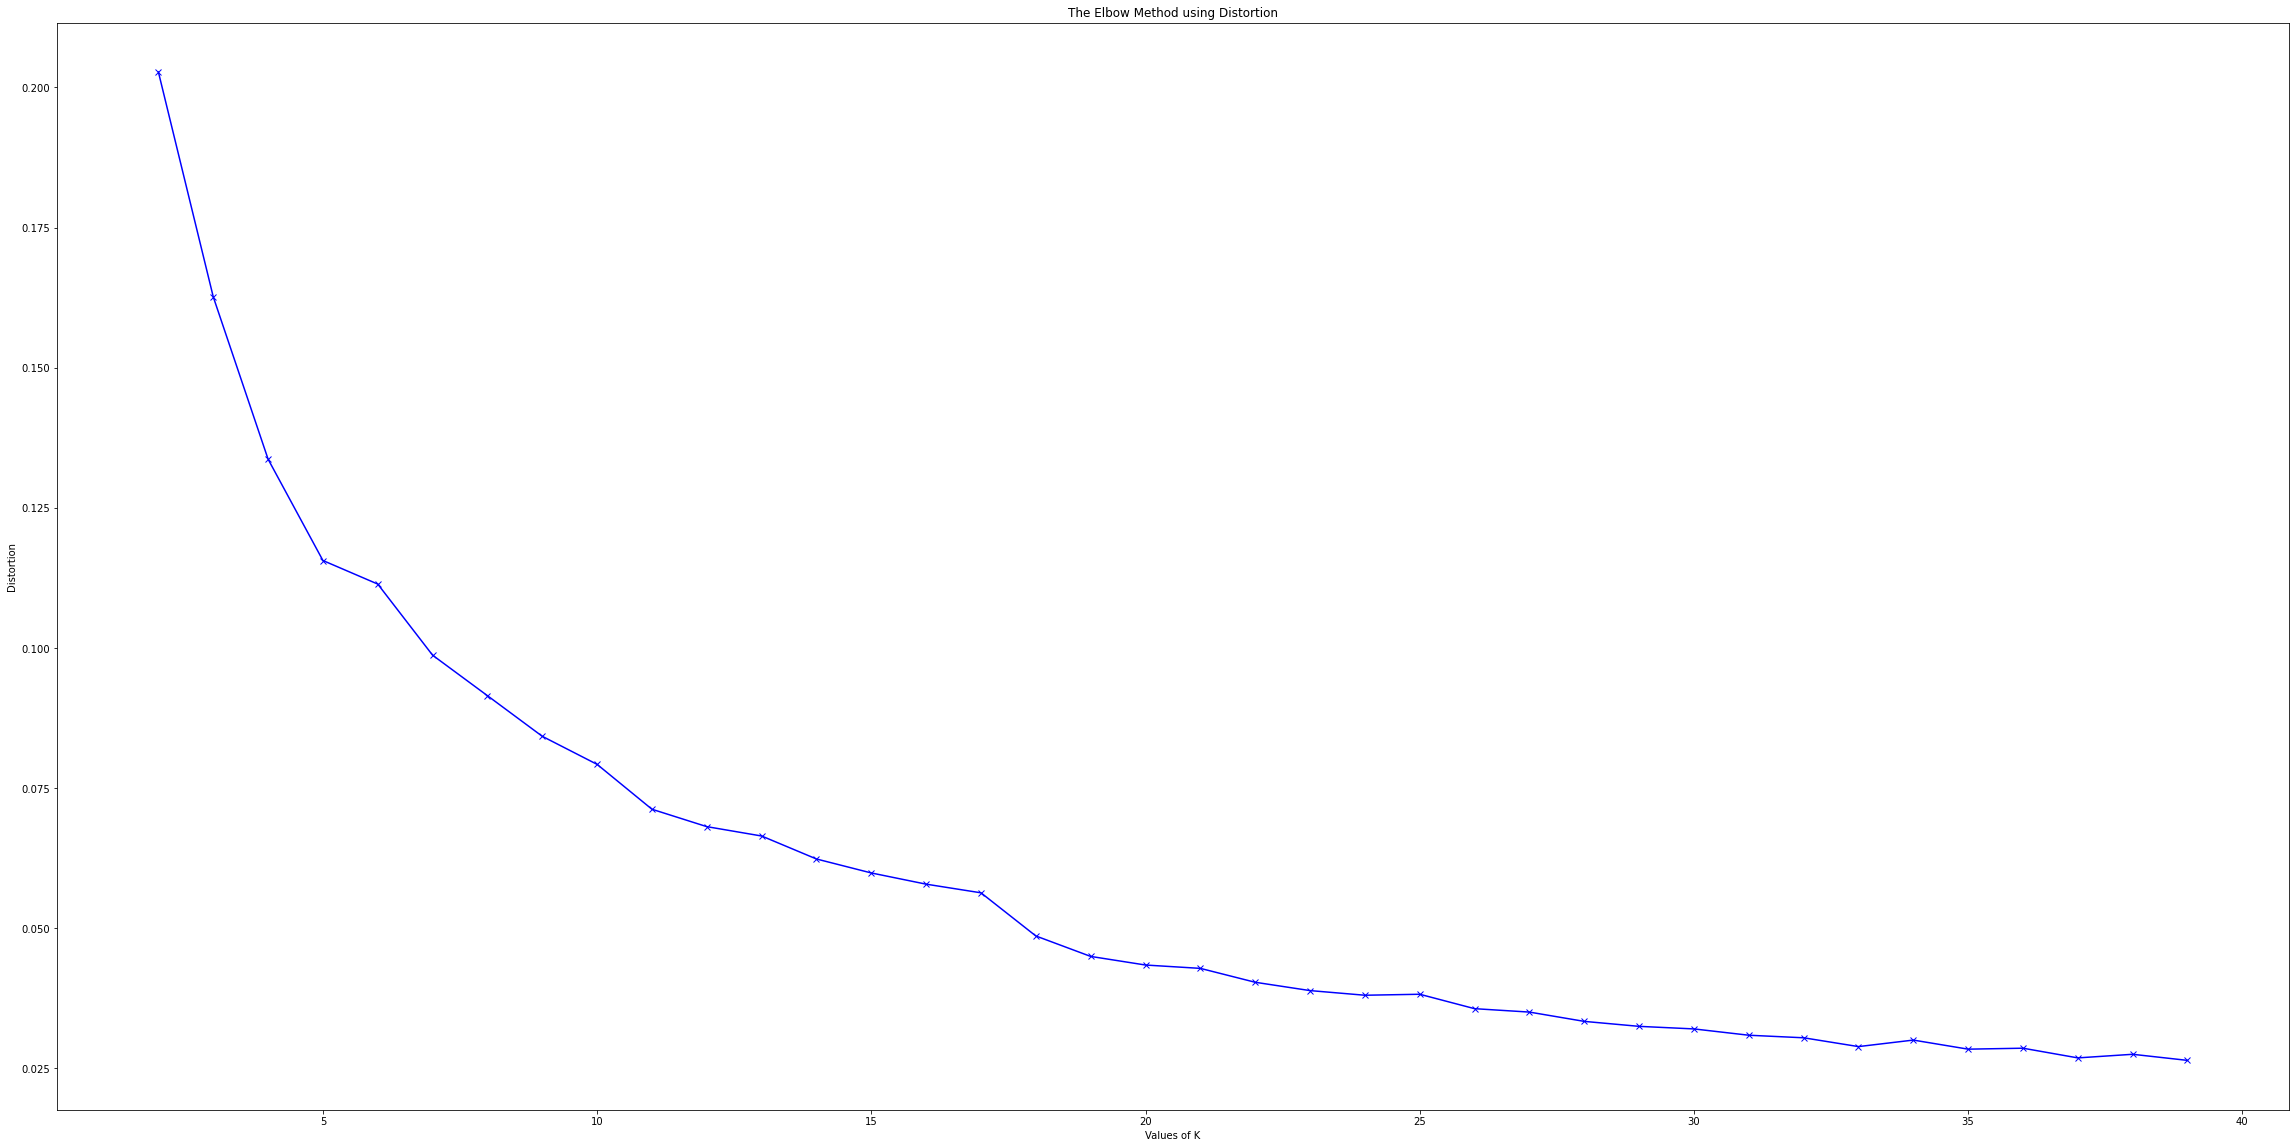

In [8]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
    return kmeans

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

cluster_min = 2
cluster_max = 40
rows = 4
fig,axes = plt.subplots(rows,int(cluster_max/rows),figsize=(40,20))
    
for n in range(cluster_min,cluster_max):
    km = KMeans(n_clusters=n) 
    row = int(np.floor(n / axes.shape[1]))
    col = int(n - (row * axes.shape[1]))
    km = plot_kmeans(km, sample, n_clusters=n, ax=axes[row,col])
    
    distortions.append(sum(np.min(cdist(sample, km.cluster_centers_,
                                        'euclidean'), axis=1)) / sample.shape[0])
    inertias.append(km.inertia_)
  
    mapping1[n] = sum(np.min(cdist(sample, km.cluster_centers_,
                                   'euclidean'), axis=1)) / sample.shape[0]
    mapping2[n] = km.inertia_

plt.figure(figsize=(40,20))
    
plt.plot(range(cluster_min,cluster_max), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()



#### Output KMeans weights for classification of geo locations

In [11]:
### Geo clustering w/ KMeans
points = get_points()

### Derived from elbow method analysis above
geo_classes = 19
classifier_geo = KMeans(n_clusters=geo_classes) 
classifier_geo.fit(points)

# save out GMM clusters for use in distributed model classification
with open('geo_model_kmeans.pkl','wb') as f:
    pickle.dump(classifier_geo,f)

#### Test KMeans clustering

19


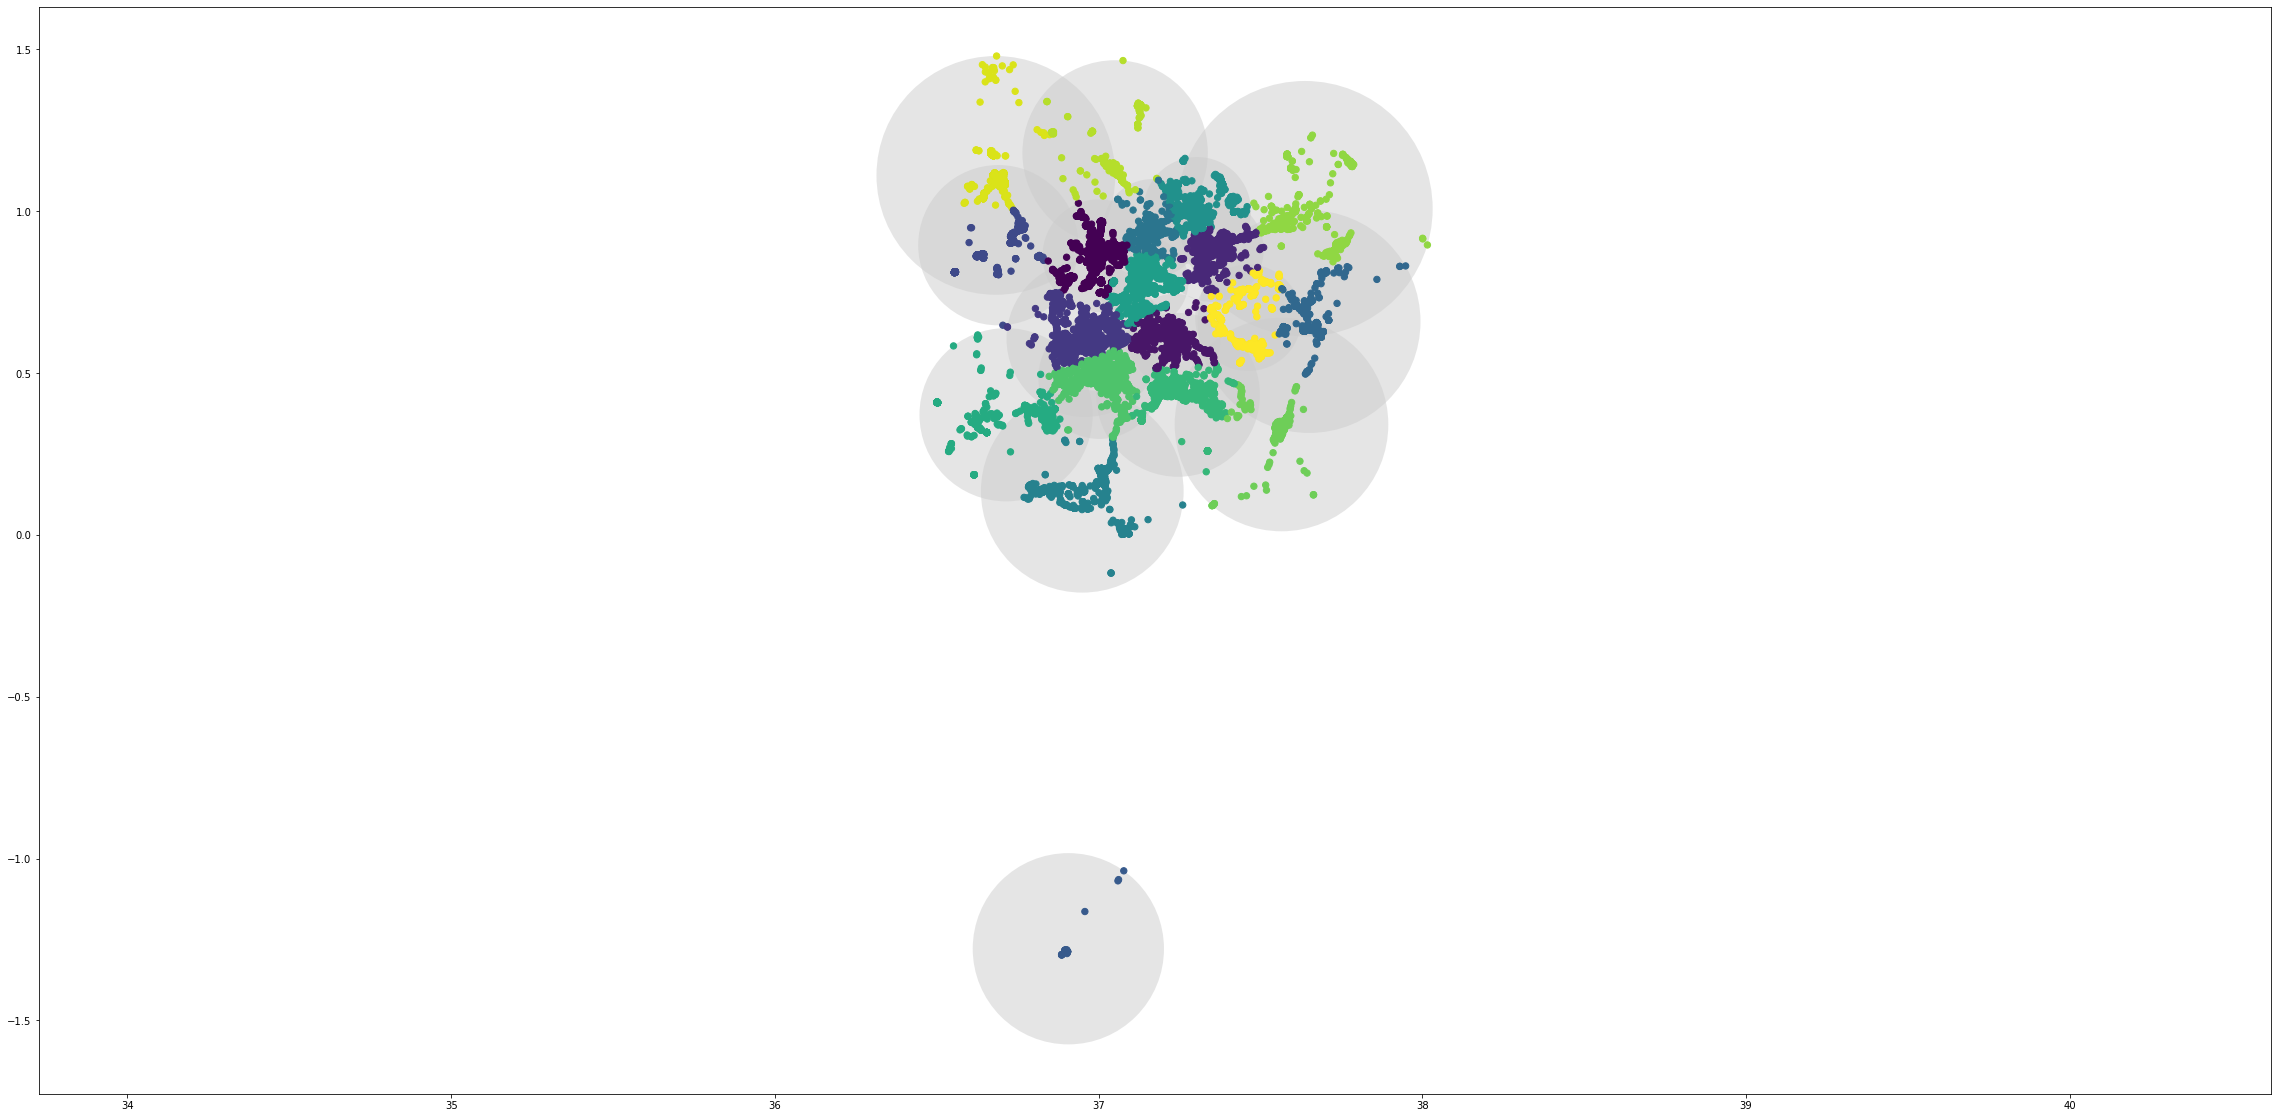

In [12]:
points = get_points()
sample = np.array(random.sample(list(points),50000))

with open('geo_model_kmeans.pkl', 'rb') as f:
    classifier_geo = pickle.load(f)
    geo_classes = classifier_geo.n_clusters
    
    print(geo_classes)
    
    fig,ax = plt.subplots(figsize=(40,20))
    plot_kmeans(classifier_geo, sample, n_clusters=geo_classes, rseed=0, ax=ax)